### TODO:
* Tensorize
* Organize transforms
* Organize weight initializations
* Base ResNet to identify what pets are in consideration
* Organize gradient settings
* Refactor model selection to create universal approach for adjusting final layer

# General Imports and Setup

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import shutil
# from skimage import io, transform
# from skimage import io
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from functools import partial
import logging
import yaml
from typing import Optional


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/elandg/ml/Pawpularity/env/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/elandg/ml/Pawpularity/env/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/elandg/ml/Paw

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce GTX 1050


In [4]:
# ROOT_DIR = '/home/elandg/ml/Pawpularity'
ROOT = os.getcwd()
print(ROOT)
DATA_PATH = os.path.join(ROOT, "data/")
print(DATA_PATH)
data_path_partial = partial(os.path.join, DATA_PATH)

/home/elandg/ml/Pawpularity
/home/elandg/ml/Pawpularity/data/


# Competition Download

Uncomment and run these code cells to load the dataset.

In [6]:
# # ! pip uninstall -y kaggle # run if error '429' when trying to download competition
# % cd /content/drive/MyDrive/'Colab Notebooks"/Pawpularity
# ! mkdir ~/.kaggle
# ! cp ../kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! pip install -q kaggle --upgrade
# ! kaggle -v
# ! kaggle competitions download -c petfinder-pawpularity-score -o
# ! ls

In [7]:
# ! kaggle competitions download -h

In [8]:
# ! unzip -q -o petfinder-pawpularity-score.zip

<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
        the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



# Create Dataset

In [4]:
# Read in config
with open(os.path.join(ROOT, "config/config.yaml")) as f:
    cf = yaml.safe_load(f)

num_bins = cf["num_bins"]

NameError: name 'os' is not defined

In [10]:
"""Generate CSV"""
def bin_csv(csv_path_callable: callable = data_path_partial,
             num_bins: int = 100, 
             save_binned_csv: bool = False) -> pd.DataFrame:
    """
    Loads and bins base csv, which has labels of Pawpularity scores 1-100
    Avoid binning by passing num_bins = 100 or leaving it default
    """
    if num_bins and not (1 <= num_bins <= 100):
        logging.warning(f"num_bins should be between 1 and 100. \
              Pawpularity ranges from 1-100 and is rescaled to 0-99")
    
    df_raw = pd.read_csv(csv_path_callable("train.csv"))

    # Change labels to 0-99
    df_rescaled = df_raw.assign(Pawpularity=df_raw["Pawpularity"] - 1)
    df_binned = df_rescaled.assign(Pawpularity=df_rescaled["Pawpularity"].floordiv(100/num_bins).astype(int))

    if save_binned_csv:
        df_binned.to_csv(csv_path_callable(f"train_{num_bins}_bins.csv"), index=False)

    return df_binned

df = bin_csv(num_bins=100, save_binned_csv=True)
# df = bin_csv(save_binned_csv=True)

# df_raw.head()
# print(df.head())
print(df.sort_values(by="Pawpularity", ascending=False).head())
# df_binned_10.head()
# df_binned_5.head()

                                    Id  Subject Focus  Eyes  Face  Near  \
6930  b2eed3052c0e2d8965dfea7b50d04676              0     1     1     1   
7265  bb018056345d6332499b0640196a2359              0     0     1     1   
9519  f5e841dbe4a37954cd762022af45896b              0     1     1     1   
8347  d82afe0c787d654fc4a7be069e8cba9b              0     1     1     1   
2926  4b969d7a5e55de08660c6affb8dcf04c              0     1     1     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
6930       0          0      0        0      0          0     0     0   
7265       0          0      0        0      0          0     0     1   
9519       0          0      0        0      0          0     0     0   
8347       0          0      0        0      0          1     0     0   
2926       0          0      0        0      0          0     0     0   

      Pawpularity  
6930           99  
7265           99  
9519           99  
8347           99  
2926      

In [21]:
class PawpularityDataset(Dataset):
    """Pawpularity dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.num_classes = self.df["Pawpularity"].max() + 1

    def __len__(self):
            return len(self.df)

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        
        # pd.loc can retrieve multiple rows/columns
        metadata = torch.tensor(self.df.loc[idx, "Subject Focus":"Blur"])

        # pd.at is faster than pd.loc but only works for single values
        img_path = os.path.join(self.root_dir,
                                self.df.at[idx, "Id"] + ".jpg")

        image = read_image(img_path)
        if self.transform:
            self.transform(image)
        # score = torch.tensor(self.df.at[idx, 'Pawpularity'] - 1).float()
        score = self.df.at[idx, "Pawpularity"]

        return {"image": image, "metadata":metadata, "score": score}
    
    def get_img_sizes(self, append_to_df=True, verbose=False):
        img_sizes = []
        count = 0
        if "Shape" not in self.df.columns:
            for i in range(len(self)):
                if verbose and count % 1000 == 0:
                    print(count)
                img = self[i]["image"]
                img_sizes.append(img.shape)
                self.df
                count += 1
            if verbose:
                print(count)
            if append_to_df:
                self.df["Shape"] = img_sizes
        else:
            print(len(self.df))
            img_sizes = self.df["Shape"]
        img_sizes = [torch.tensor(x) for x in img_sizes]
        return torch.vstack(img_sizes)
    
    def clean_csv(self):
        self.df.drop("Shape", inplace=True)
            
# Parameters for "Data Analysis"
csv_file = data_path_partial(f"train_{num_bins}_bins.csv")
images = data_path_partial("train_images")

# transform = transforms.Compose([
#         transforms.ToTensor(),
#         # transforms.Resize(IMG_SIZE)
# ])
transform = None
dataset = PawpularityDataset(csv_file, images, transform=transform)

# Data Analysis

In [22]:
batch_size_da = cf["bs_da"]
dataloader = DataLoader(dataset, batch_size=batch_size_da, shuffle=False, num_workers=2)

0 99


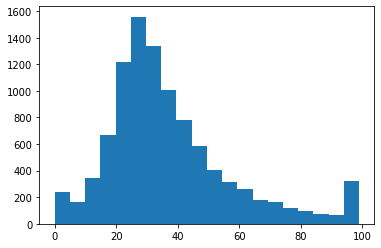

In [23]:
scores = dataset.df["Pawpularity"]
_ = plt.hist(scores, bins=20)
print(min(scores), max(scores))

9912


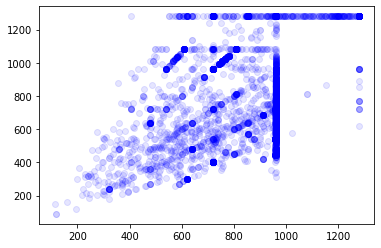

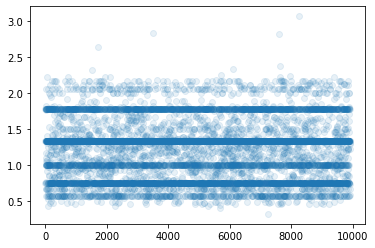

torch.return_types.max(
values=tensor([   3, 1280, 1280]),
indices=tensor([0, 7, 7]))


In [33]:
def plot_scatter_sizes(img_sizes):
    img_sizes = img_sizes
    plt.scatter(img_sizes[:,1], img_sizes[:,2], color="blue", alpha=.1)
    plt.show()

def plot_scatter_ratios(img_sizes):
    # print(img_sizes[:,0] / img_sizes[:,1])
    # dist of aspect ratios
    plt.scatter(range(len(img_sizes)), img_sizes[:,1] / img_sizes[:,2], alpha=.1)
    plt.show()

def largest_n_img_sizes(img_sizes, top_n=5):
    print(torch.max(img_sizes, dim=0))

    # x = torch.tensor([[1,2,3], [4,5,6], [7,8,9]])

    # vals, counts = torch.unique(img_sizes, return_counts=True, dim=0) # returns unique H x W pairings and counts for each pairing
    # sum_vals = vals[:, 1] + vals[:, 2]

    # print(torch.sort(vals, dim=0))
    # print(len(vals))
    # print(torch.sort(counts))

def run_long_analysis(dataset):

    img_sizes = dataset.get_img_sizes(verbose=True)

    plot_scatter_sizes(img_sizes)
    plot_scatter_ratios(img_sizes)
    largest_n_img_sizes(img_sizes)

run_long_analysis(dataset)

# Design Model

In [34]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

metrics = cf["metrics"]

criterions = []
if "ce" in metrics:
    criterions.append({"name": "CE", "criterion":nn.CrossEntropyLoss()})
if "mse" in metrics:
    criterions.append({"name": "MSE", "criterion":nn.MSELoss()})
# criterions.append({'name': "MSE", 'criterion':nn.MSELoss()})
# criterions.append({'name': 'CE', 'criterion':nn.CrossEntropyLoss()})
# criterion = RMSELoss()
# criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss()

In [39]:
import re

from torchvision.models import inception_v3, Inception_V3_Weights, \
                                resnet50, ResNet50_Weights, \
                                alexnet, AlexNet_Weights, \
                                vgg19_bn, VGG11_BN_Weights, \
                                densenet201, DenseNet201_Weights, \
                                efficientnet_b7, EfficientNet_B7_Weights, \
                                efficientnet_v2_l, EfficientNet_V2_L_Weights

# Initialize weights to small random values ("speeds up training")
# Should not use if loading pretrained weights
def initialize_weights(module):
    # print(module)
    if isinstance(module, nn.Conv2d):
        nn.init.uniform_(module.weight.data)
        if module.bias is not None:
            nn.init.constant_(module.bias.data, 0)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.uniform_(module.weight.data)
        nn.init.uniform_(module.bias.data)
    elif isinstance(module, nn.Linear):
        nn.init.uniform_(module.weight.data)
        if module.bias is not None:
            nn.init.constant_(module.bias.data, 0)

# model requires grad by default
# if we dont have weights aka FE is false
#     all layers require grad
# else we do have weights aka FE is true
#     all layers except last dont require grad

# Finetuning is taking a pretrained model and training more
# Feature extracting is using the pretrained model to extract features adnd only training final layers to make inference from extracted features
# Only training final layer if feature_extracting=True
def set_parameter_requires_grad(model, freeze_backbone):
    if freeze_backbone:
        print(model.parameters())
        for param in model.parameters():
            param.requires_grad = False


class MetaNet(nn.Module):
    def __init__(self, backbone, bb_output_size, num_classes):
        super(MetaNet, self).__init__()
        self.name = backbone.name + "_meta"
        self.backbone = backbone
        self.fc1 = nn.Linear(bb_output_size + 12, 64) # 12 values from metadata
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

        modules = [self.fc1, self.fc2, self.fc3]
        for module in modules: #TODO: find way to look through only layers added by this module
            initialize_weights(module)
        
    def forward(self, image, data):
        if self.backbone.name == "inception":
            x1 = F.relu(self.backbone(image).logits)
        else:
            x1 = F.relu(self.backbone(image))
        x2 = data
        
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def initialize_model(model_name, 
                     num_classes, 
                     use_metadata=False, 
                     freeze_backbone=False, 
                     pretrained_weights=None):
        # Initialize these variables which will be set in this if statement. Each of these
        # variables is model specific.
        model_ft = None
        transform = None
        input_size = 0


        if use_metadata:
            output_size = 256 # hyperparameter

        if model_name == "resnet":
            """ Resnet18
            """
            model_ft = models.resnet50(weights=pretrained_weights)
            set_parameter_requires_grad(model_ft, freeze_backbone)
            num_ftrs = model_ft.fc.in_features
            if use_metadata:
                model_ft.fc = nn.Linear(num_ftrs, output_size)
            else:
                model_ft.fc = nn.Linear(num_ftrs, num_classes)
            initialize_weights(model_ft.fc)
            input_size = 232

        elif model_name == "alexnet":
            """ Alexnet
            """
            model_ft = models.alexnet(weights=pretrained_weights)
            set_parameter_requires_grad(model_ft, freeze_backbone)
            num_ftrs = model_ft.classifier[6].in_features
            model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
            initialize_weights(model_ft.classifier[6])
            input_size = 224

        elif model_name == "vgg":
            """ VGG11_bn
            """
            model_ft = models.vgg11_bn(weights=pretrained_weights)
            set_parameter_requires_grad(model_ft, freeze_backbone)
            num_ftrs = model_ft.classifier[6].in_features
            model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
            initialize_weights(model_ft.classifier[6])
            input_size = 224

        elif model_name == "squeezenet":
            """ Squeezenet
            """
            model_ft = models.squeezenet1_0(weights=pretrained_weights)
            set_parameter_requires_grad(model_ft, freeze_backbone)
            model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
            initialize_weights(model_ft.classifier[1])
            # model_ft.num_classes = num_classes # Doesn't seem to be needed but used in PyTorch documentation
            input_size = 224

        elif model_name == "densenet":
            """ Densenet
            """
            model_ft = models.densenet121(weights=pretrained_weights)
            set_parameter_requires_grad(model_ft, freeze_backbone)
            num_ftrs = model_ft.classifier.in_features
            model_ft.classifier = nn.Linear(num_ftrs, num_classes)
            initialize_weights(model_ft.classifier)
            input_size = 224

        elif model_name == "inception":
            """ Inception v3
            Be careful, expects (299,299) sized images and has auxiliary output
            """
            model_ft = models.inception_v3(weights=pretrained_weights)
            set_parameter_requires_grad(model_ft, freeze_backbone)
            # Handle the auxilary net
            num_ftrs = model_ft.AuxLogits.fc.in_features
            model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
            initialize_weights(model_ft.AuxLogits.fc)
            # Handle the primary net
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, num_classes)
            initialize_weights(model_ft.fc)
            input_size = 299
        
        # Too large
        elif model_name == "convnext":
            """ ConvNeXt
            """
            model_ft = models.convnext_large(weights=pretrained_weights)
            set_parameter_requires_grad(model_ft, freeze_backbone)
            num_ftrs = model_ft.classifier[2].in_features
            model_ft.classifier[2] = nn.Linear(num_ftrs, num_classes)
            initialize_weights(model_ft.classifier[2])
            input_size = 232

        # Too large
        elif model_name == "efficient_b7":
            """ EfficientNet
            """
            model_ft = models.efficientnet_b7(weights=pretrained_weights)
            set_parameter_requires_grad(model_ft, freeze_backbone)
            num_ftrs = model_ft.classifier[1].in_features
            model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)
            initialize_weights(model_ft.classifier[1])
            input_size = 600

        elif model_name == "efficient_V2_L":
            """ EfficientNet
            """
            model_ft = models.efficientnet_v2_l(weights=pretrained_weights)
            set_parameter_requires_grad(model_ft, freeze_backbone)
            num_ftrs = model_ft.classifier[1].in_features
            model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)
            initialize_weights(model_ft.classifier[1])
            input_size = 480

        else:
            print("Invalid model name, exiting...")
            exit()

        
        # with open('model.txt', 'w') as f:
        #     print(model_ft, file=f);
        
        model_ft.name = model_name
        if use_metadata:
            model_ft = MetaNet(model_ft, output_size, num_classes)

        # Can pass in pretrained model weights and transforms or start fresh with only model architecture
        if pretrained_weights:
            # set_parameter_requires_grad(model_ft)
            # transform = pretrained_weights.transforms()
            # https://stackoverflow.com/questions/3075130/what-is-the-difference-between-and-regular-expressions
            # https://stackoverflow.com/questions/6109882/regex-match-all-characters-between-two-strings
            input_size = int(re.search("(?<=resize_size=)([^Z]*)(?=,)|(?<=resize_size=)([^Z]*)(?=\))", str(pretrained_weights.transforms)).group(0))
            # input_size = int(re.search('(?<=resize_size=)([^Z]*)(?=\n)', str(transform)).group(0)) # struggling to recognize characters in str
        else:
            for module in model_ft.modules():
                initialize_weights(module)
            transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize(IMG_SIZE),
                            transforms.Normalize(
                                mean=[0.5188, 0.4840, 0.4462],
                                std=[0.2681, 0.2639, 0.2659]
                            )
                        ])

        return model_ft, input_size, transform

model_dicts = [
    {"name": "resnet", "model": models.resnet50, "weights": ResNet50_Weights.IMAGENET1K_V2},
    {"name": "alexnet", "model": models.alexnet, "weights": AlexNet_Weights.IMAGENET1K_V1},
    {"name": "vgg", "model": models.vgg11, "weights": VGG11_BN_Weights.IMAGENET1K_V1},
    {"name": "squeezenet", "model": models.squeezenet1_0, "weights": None},
    {"name": "densenet", "model": models.densenet121, "weights": DenseNet201_Weights.IMAGENET1K_V1},
    {"name": "inception", "model": models.inception_v3, "weights": Inception_V3_Weights.IMAGENET1K_V1},
    {"name": "convnext", "model": models.convnext_large, "weights": None},
    {"name": "efficient_b7", "model": models.efficientnet_b7, "weights": EfficientNet_B7_Weights.IMAGENET1K_V1},
    {"name": "efficient_V2_L", "model": models.efficientnet_v2_l, "weights": EfficientNet_V2_L_Weights.IMAGENET1K_V1},
]

model_dict = model_dicts[cf["model"]]
model_name = model_dict["name"]
# if criterions[0]['name'] == 'CE':
if any([criterion["name"] == "CE" for criterion in criterions]):
    num_classes = dataset.num_classes
else:
    num_classes = 1
print(f"Num classes: {num_classes}")
# pretrained_weights = None
pretrained_weights = model_dict["weights"]
use_metadata = True

# Initialize the model for this run
net, img_size, transform = initialize_model(model_name, 
                                            num_classes, 
                                            use_metadata=use_metadata, 
                                            freeze_backbone=True, 
                                            pretrained_weights=pretrained_weights)
IMG_SIZE = (img_size, img_size)

# Print the model we just instantiated
with open("model.txt", "w") as f:
    print(net, file=f);

net.to(device);

# calc new rgb mean and std with new image size?
# be able to have a shortcut button to run selected cell cluster that is always on the screen. similar to run above and cell/below
# Functionality handled by lambda in optimizer but good to sanity check
with open("weights.txt", "w") as f:
    f.write("Params to learn: \n")
    for name, param in net.named_parameters():
        if param.requires_grad == True:
            f.write(f"\t {name}\n")


# Passing frozen layers into optimizer should produce an error
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.8, dampening=0, weight_decay=0.00005)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.0001)

Num classes: 1
<generator object Module.parameters at 0x7f76cdc052a0>


In [18]:
transform = transforms.Compose([
        transforms.Resize(IMG_SIZE)
])
# transform = None
dataset = PawpularityDataset(csv_file, images, transform=transform)
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for sample in dataloader:
        data = sample["image"]
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

# mean, std = get_mean_and_std(dataloader)
# print(f'mean: {mean}, std: {std}') # mean: [0.5188, 0.4840, 0.4462] std: [0.2681, 0.2639, 0.2659]

In [19]:
# N must be > 1 if using batch norm layer
input_shape = ((2, 3) + IMG_SIZE)
input_imgs = torch.zeros(input_shape)
if use_metadata:
    input_metadata = torch.zeros((2, 12))
    output = net(input_imgs.to(device), input_metadata.to(device))
else:
    output = net(input_imgs.to(device))

print(output)
# print(output.T[0].float())
# print(output.argmax(1).float())

tensor([[3464301.7500],
        [3464301.7500]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [20]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(t)
print(r)
print(a)
print(f)
torch.cuda.mem_get_info()

4294836224
176160768
97003008
79157760


(2708471808, 4294836224)

# Prepare Data

In [21]:
# Run to compute optimal number of workers for system
from time import time
import multiprocessing as mp

def find_opt_num_workers(trainset, batch_size):
    opt_num_workers = 0
    min_time = float('inf')
    for num_workers in range(2, mp.cpu_count(), 2):  
        tr_loader = DataLoader(trainset, shuffle=True, num_workers=num_workers, batch_size=batch_size, pin_memory=False)
        start = time()
        for epoch in range(1, 3):
            for i, data in enumerate(tr_loader, 0):
                pass
        end = time()
        timespan = end - start
        if timespan < min_time:
            opt_num_workers = num_workers
            min_time = timespan
        print("Finish with:{} second, num_workers={}".format(end - start, num_workers))
    return opt_num_workers

opt_num_workers = find_opt_num_workers()

opt_num_workers = 4

batch_size = 16

dataset = PawpularityDataset(csv_file, images, transform=transform)

# 9912 samples total
trainset, valset, testset = torch.utils.data.random_split(dataset, [6912, 2000, 1000])

tr_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=opt_num_workers)

val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=True, num_workers=opt_num_workers)

te_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=opt_num_workers)

TypeError: find_opt_num_workers() missing 2 required positional arguments: 'trainset' and 'batch_size'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


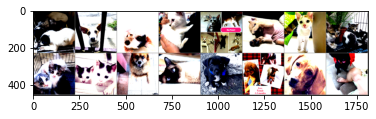

  3   3   2   4   2   3   4   2   6   1   9   2   5   1   1   4


In [ ]:
# function to show an image - seems like images are not restored properly
def imshow(img):
    # print(img.size()) # 8 x 4 grid casuses shape of 1810 x 906
    img = img / 2 + 0.5         # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # print(img.size())
    # stds = [0.2681, 0.2639, 0.2659]
    # means = [0.5188, 0.4840, 0.4462]
    # img = np.dstack((img[i] * stds[i] + means[i] for i in range(3)))
    # img = img * [0.2681, 0.2639, 0.2659] + [0.5188, 0.4840, 0.4462]
    plt.show()


# get some random training images
dataiter = iter(te_loader)
# Keeps breaking after training?

batch = dataiter.next()
# print(batch['image'].size())

# show images
imshow(torchvision.utils.make_grid(batch['image']))
classes = [i for i in range(num_classes)]
# print(classes)

# print labels
# print(batch['score'][0])
# print(classes)
# print(' '.join('%3s' % range(100)[batch['score'][j]] for j in range(batch_size)))
if num_classes == 1:
    print(' '.join('%3s' % range(100)[int(batch['score'][j].item())] for j in range(batch_size))) # bug with 9s reported as 99
    print(batch['score'])
else:
    print(' '.join('%3s' % classes[int(batch['score'][j].item())] for j in range(batch_size))) # Use classes[...] to remove tensor notation

# Train Model

In [ ]:
# from sklearn.metrics import mean_absolute_error
mean_absolute_error = nn.L1Loss()

# TODO: if path exists, print the stats to a text file all at once at the end
def log_training(epoch, stats, metric_labels, path=None):
    """Print the train, validation, test accuracy/loss/auroc.

    Each epoch in `stats` should have order
        [val_acc, val_loss, val_auc, train_acc, ...]
    Test accuracy is optional and will only be logged if stats is length 9.
    """
    splits = ["Val", "Train", "Test"]
    print(f'Epoch {epoch}')
    for j, split in enumerate(splits):
        for i, m in enumerate(metric_labels):
            idx = len(metric_labels) * j + i
            if idx >= len(stats[-1]):
                continue
            print(f'\t{split} {m}: {round(stats[-1][idx], 4)}')
    # include_train = len(stats[-1]) / 3 == 3
    # splits = ["Validation", "Train", "Test"]
    # metrics = ["Accuracy", "Loss", "MAE"]
    # if path is not None:
    #     with open(path, 'a') as f:
    #         print("Epoch {}".format(epoch), file=f)
    #         for j, split in enumerate(splits):
    #             for i, metric in enumerate(metrics):
    #                 idx = len(metrics) * j + i
    #                 if idx >= len(stats[-1]):
    #                     continue
    #                 print(f"\t{split} {metric}:{round(stats[-1][idx],4)}", file=f)
    # else:
    #     print("Epoch {}".format(epoch))
    #     for j, split in enumerate(splits):
    #         for i, metric in enumerate(metrics):
    #             idx = len(metrics) * j + i
    #             if idx >= len(stats[-1]):
    #                 continue
    #             print(f"\t{split} {metric}:{round(stats[-1][idx],4)}")

def print_plots(epoch, stats, metric_labels, name="CNN Training", path=None):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(name)
    # axes[0].set_xlabel("Epoch")
    # axes[0].set_ylabel("Accuracy")
    # axes[1].set_xlabel("Epoch")
    # axes[1].set_ylabel("Loss")
    # axes[2].set_xlabel("Epoch")
    # axes[2].set_ylabel("AUROC")

    splits = ["Validation", "Train", "Test"]
    colors = ["r", "b", "g"]
    for i, metric in enumerate(metric_labels):
        for j, split in enumerate(splits):
            idx = len(metric_labels) * j + i
            if idx >= len(stats[-1]):
                continue
            # __import__('pdb').set_trace()
            axes[i].plot(
                range(epoch - len(stats) + 1, epoch + 1),
                [stat[idx] for stat in stats],
                linestyle="--",
                marker="o",
                color=colors[j],
            )
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metric_labels[i])
        axes[i].legend(splits[: int(len(stats[-1]) / len(metric_labels))])
    if path:
        plt.savefig(path)
    plt.pause(0.00001)

def predictions(model_name, loss_criterion, output):
    # print(logits.size())
    if loss_criterion['name'] == 'CE':
        if 'inception' == model_name:
            pred = output.logits.argmax(axis=1).float()
        else:
            pred = output.argmax(axis=1).float()
    else:
        if 'inception' == model_name:
            pred = output.logits.T[0].float()
        else:
            pred = output.T[0].float()

    return pred

def train_epoch(data_loader, model, use_metadata, loss_criterion, optimizer):
    for i, sample in enumerate(data_loader, 0):
        # inputs, labels = data
        inputs = sample['image'].to(device)
        labels = sample['score'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        if use_metadata:
            metadata = sample['metadata'].to(device)
            output = model(inputs, metadata)
        else:
            output = model(inputs)
        loss = loss_criterion['criterion'](output, labels)
        loss.backward()
        optimizer.step()

def evaluate_epoch(tr_loader, val_loader, te_loader, model, use_metadata, epoch, metric_labels, loss_criterion, criterions=[], stats=[], include_test=False, path=None):
    def _get_metrics(loader):
        correct, total = 0, 0
        # batch_size defined during data loader creation, TODO: clean up
        running_loss = []
        for sample in loader:
            with torch.no_grad():
                inputs = sample['image'].to(device)
                labels = sample['score']

                if use_metadata:
                    metadata = sample['metadata'].to(device)
                    output = model(inputs, metadata)
                else:
                    output = model(inputs)
                predicted = predictions(model.name, loss_criterion, output).cpu()
                
                total += labels.size(0)
                # labels = labels.to(device)
                # correct += (torch.abs(predicted - labels) < 5).sum().item()
                if loss_criterion['name'] == 'CE':
                    correct += (predicted == labels).sum().item()
                    # print(f'predicted: {predicted}, labels: {labels}')
                else:
                    correct += (torch.div(predicted, 10, rounding_mode='floor') - torch.div(labels, 10, rounding_mode='floor')).sum().item()
                # print(predicted, labels)
                # print(loss_criterion)
                # print(loss_criterion(predicted, labels))
                running_loss.append(loss_criterion['criterion'](output, labels.to(device)).cpu())
        loss = np.mean(running_loss)
        # print(loss)
        acc = correct / total
        # mae = mean_absolute_error(predicted, labels.to(device)).item()
        return [acc, loss]

    train_stats = _get_metrics(tr_loader)
    # print(f'Train Acc: {train_acc}, Loss: {train_loss}, AUC: {train_auc}')
    val_stats = _get_metrics(val_loader)
    # print(f'Val Acc: {val_acc}, Loss: {val_loss}, AUC: {val_auc}')

    # stats_at_epoch = [
    #     val_acc,
    #     val_loss,
    #     val_auc,
    #     train_acc,
    #     train_loss,
    #     train_auc,
    # ]
    stats_at_epoch = []
    stats_at_epoch.extend(val_stats)
    stats_at_epoch.extend(train_stats)

    if include_test:
        stats_at_epoch.extend(_get_metrics(te_loader))

    stats.append(stats_at_epoch)
    # print(stats)
    log_training(epoch, stats, metric_labels, path)
    
    return stats


In [ ]:
save_name = net.name + '_1'
MODEL_PATH = os.path.join(ROOT, save_name + '.pt')
MODEL_STATS_PATH = os.path.join(ROOT, save_name + '.txt')
open(MODEL_STATS_PATH, 'w').close()
MODEL_GRAPHS_PATH = os.path.join(ROOT, save_name + '.jpg')

print(f'Training for {save_name}')

epoch = 0
max_epochs = 150
patience = 5
curr_patience_count = 0
metric_labels = ['ACC'] + [criterion['name'] for criterion in criterions]
loss_criterion = criterions[0]
# total[train, val, test[metric_labels[vals each epoch]]] potential reordering for stats
stats = []
include_test = False
stats = evaluate_epoch(tr_loader, val_loader, te_loader, net, use_metadata, epoch, metric_labels, loss_criterion, criterions=criterions, stats=stats, include_test=include_test, path=MODEL_STATS_PATH)
epoch += 1
global_min_loss = stats[0][1] # starting val loss

# for epoch in range(num_epochs):
while epoch < max_epochs and curr_patience_count < patience:
    train_epoch(tr_loader, net, use_metadata, loss_criterion, optimizer)

    stats = evaluate_epoch(tr_loader, val_loader, te_loader, net, use_metadata, epoch, metric_labels, loss_criterion, criterions=criterions, stats=stats, include_test=include_test, path=MODEL_STATS_PATH)

    # print(stats)
    
    if stats[-1][1] < global_min_loss:
        curr_patience_count = 0
        global_min_loss = stats[-1][1]
        torch.save(net.state_dict(), MODEL_PATH)
    else:
        curr_patience_count += 1
    
    epoch += 1

print('Finished Training')
print_plots(epoch, stats, path=MODEL_GRAPHS_PATH)
#E Tutorial had 54% accuracyfnet
#E A good loss is below .5 but varies depending on application and dataset

Training for resnet_meta_1
Epoch 0
	Val ACC: 0.0395
	Val CE: 62574.2578125
	Train ACC: 0.0404
	Train CE: 61652.82421875
Epoch 1
	Val ACC: 0.0955
	Val CE: 13969.263671875
	Train ACC: 0.0959
	Train CE: 13638.0625
Epoch 2
	Val ACC: 0.229
	Val CE: 44.33610153198242
	Train ACC: 0.2148
	Train CE: 45.152099609375
Epoch 3
	Val ACC: 0.158
	Val CE: 58.97760009765625
	Train ACC: 0.16
	Train CE: 59.740699768066406
Epoch 4
	Val ACC: 0.182
	Val CE: 50.775699615478516
	Train ACC: 0.1914
	Train CE: 49.57820129394531
Epoch 5
	Val ACC: 0.2275
	Val CE: 42.676300048828125
	Train ACC: 0.2412
	Train CE: 41.87409973144531
Epoch 6
	Val ACC: 0.1325
	Val CE: 40.97669982910156
	Train ACC: 0.1386
	Train CE: 39.83430099487305
Epoch 7
	Val ACC: 0.1425
	Val CE: 41.27320098876953
	Train ACC: 0.1496
	Train CE: 39.79209899902344
Epoch 8
	Val ACC: 0.141
	Val CE: 49.29710006713867
	Train ACC: 0.1623
	Train CE: 48.45589828491211
Epoch 9
	Val ACC: 0.244
	Val CE: 40.27980041503906
	Train ACC: 0.2533
	Train CE: 37.5793991088

KeyboardInterrupt: 

# Test Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


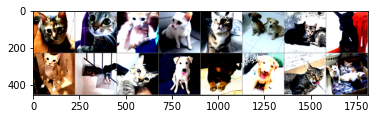

GroundTruth:     32    18    21    34    26    70    16    36    14    68    54    39    44    53     8    32


In [ ]:
dataiter = iter(te_loader)
sample = dataiter.next()
images, metadata, labels = sample['image'], sample['metadata'], sample['score']

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [ ]:
net.load_state_dict(torch.load('model1.pt'))
print(net.name)

RuntimeError: Error(s) in loading state_dict for MetaNet:
	Missing key(s) in state_dict: "backbone.conv1.weight", "backbone.bn1.weight", "backbone.bn1.bias", "backbone.bn1.running_mean", "backbone.bn1.running_var", "backbone.layer1.0.conv1.weight", "backbone.layer1.0.bn1.weight", "backbone.layer1.0.bn1.bias", "backbone.layer1.0.bn1.running_mean", "backbone.layer1.0.bn1.running_var", "backbone.layer1.0.conv2.weight", "backbone.layer1.0.bn2.weight", "backbone.layer1.0.bn2.bias", "backbone.layer1.0.bn2.running_mean", "backbone.layer1.0.bn2.running_var", "backbone.layer1.0.conv3.weight", "backbone.layer1.0.bn3.weight", "backbone.layer1.0.bn3.bias", "backbone.layer1.0.bn3.running_mean", "backbone.layer1.0.bn3.running_var", "backbone.layer1.0.downsample.0.weight", "backbone.layer1.0.downsample.1.weight", "backbone.layer1.0.downsample.1.bias", "backbone.layer1.0.downsample.1.running_mean", "backbone.layer1.0.downsample.1.running_var", "backbone.layer1.1.conv1.weight", "backbone.layer1.1.bn1.weight", "backbone.layer1.1.bn1.bias", "backbone.layer1.1.bn1.running_mean", "backbone.layer1.1.bn1.running_var", "backbone.layer1.1.conv2.weight", "backbone.layer1.1.bn2.weight", "backbone.layer1.1.bn2.bias", "backbone.layer1.1.bn2.running_mean", "backbone.layer1.1.bn2.running_var", "backbone.layer1.1.conv3.weight", "backbone.layer1.1.bn3.weight", "backbone.layer1.1.bn3.bias", "backbone.layer1.1.bn3.running_mean", "backbone.layer1.1.bn3.running_var", "backbone.layer1.2.conv1.weight", "backbone.layer1.2.bn1.weight", "backbone.layer1.2.bn1.bias", "backbone.layer1.2.bn1.running_mean", "backbone.layer1.2.bn1.running_var", "backbone.layer1.2.conv2.weight", "backbone.layer1.2.bn2.weight", "backbone.layer1.2.bn2.bias", "backbone.layer1.2.bn2.running_mean", "backbone.layer1.2.bn2.running_var", "backbone.layer1.2.conv3.weight", "backbone.layer1.2.bn3.weight", "backbone.layer1.2.bn3.bias", "backbone.layer1.2.bn3.running_mean", "backbone.layer1.2.bn3.running_var", "backbone.layer2.0.conv1.weight", "backbone.layer2.0.bn1.weight", "backbone.layer2.0.bn1.bias", "backbone.layer2.0.bn1.running_mean", "backbone.layer2.0.bn1.running_var", "backbone.layer2.0.conv2.weight", "backbone.layer2.0.bn2.weight", "backbone.layer2.0.bn2.bias", "backbone.layer2.0.bn2.running_mean", "backbone.layer2.0.bn2.running_var", "backbone.layer2.0.conv3.weight", "backbone.layer2.0.bn3.weight", "backbone.layer2.0.bn3.bias", "backbone.layer2.0.bn3.running_mean", "backbone.layer2.0.bn3.running_var", "backbone.layer2.0.downsample.0.weight", "backbone.layer2.0.downsample.1.weight", "backbone.layer2.0.downsample.1.bias", "backbone.layer2.0.downsample.1.running_mean", "backbone.layer2.0.downsample.1.running_var", "backbone.layer2.1.conv1.weight", "backbone.layer2.1.bn1.weight", "backbone.layer2.1.bn1.bias", "backbone.layer2.1.bn1.running_mean", "backbone.layer2.1.bn1.running_var", "backbone.layer2.1.conv2.weight", "backbone.layer2.1.bn2.weight", "backbone.layer2.1.bn2.bias", "backbone.layer2.1.bn2.running_mean", "backbone.layer2.1.bn2.running_var", "backbone.layer2.1.conv3.weight", "backbone.layer2.1.bn3.weight", "backbone.layer2.1.bn3.bias", "backbone.layer2.1.bn3.running_mean", "backbone.layer2.1.bn3.running_var", "backbone.layer2.2.conv1.weight", "backbone.layer2.2.bn1.weight", "backbone.layer2.2.bn1.bias", "backbone.layer2.2.bn1.running_mean", "backbone.layer2.2.bn1.running_var", "backbone.layer2.2.conv2.weight", "backbone.layer2.2.bn2.weight", "backbone.layer2.2.bn2.bias", "backbone.layer2.2.bn2.running_mean", "backbone.layer2.2.bn2.running_var", "backbone.layer2.2.conv3.weight", "backbone.layer2.2.bn3.weight", "backbone.layer2.2.bn3.bias", "backbone.layer2.2.bn3.running_mean", "backbone.layer2.2.bn3.running_var", "backbone.layer2.3.conv1.weight", "backbone.layer2.3.bn1.weight", "backbone.layer2.3.bn1.bias", "backbone.layer2.3.bn1.running_mean", "backbone.layer2.3.bn1.running_var", "backbone.layer2.3.conv2.weight", "backbone.layer2.3.bn2.weight", "backbone.layer2.3.bn2.bias", "backbone.layer2.3.bn2.running_mean", "backbone.layer2.3.bn2.running_var", "backbone.layer2.3.conv3.weight", "backbone.layer2.3.bn3.weight", "backbone.layer2.3.bn3.bias", "backbone.layer2.3.bn3.running_mean", "backbone.layer2.3.bn3.running_var", "backbone.layer3.0.conv1.weight", "backbone.layer3.0.bn1.weight", "backbone.layer3.0.bn1.bias", "backbone.layer3.0.bn1.running_mean", "backbone.layer3.0.bn1.running_var", "backbone.layer3.0.conv2.weight", "backbone.layer3.0.bn2.weight", "backbone.layer3.0.bn2.bias", "backbone.layer3.0.bn2.running_mean", "backbone.layer3.0.bn2.running_var", "backbone.layer3.0.conv3.weight", "backbone.layer3.0.bn3.weight", "backbone.layer3.0.bn3.bias", "backbone.layer3.0.bn3.running_mean", "backbone.layer3.0.bn3.running_var", "backbone.layer3.0.downsample.0.weight", "backbone.layer3.0.downsample.1.weight", "backbone.layer3.0.downsample.1.bias", "backbone.layer3.0.downsample.1.running_mean", "backbone.layer3.0.downsample.1.running_var", "backbone.layer3.1.conv1.weight", "backbone.layer3.1.bn1.weight", "backbone.layer3.1.bn1.bias", "backbone.layer3.1.bn1.running_mean", "backbone.layer3.1.bn1.running_var", "backbone.layer3.1.conv2.weight", "backbone.layer3.1.bn2.weight", "backbone.layer3.1.bn2.bias", "backbone.layer3.1.bn2.running_mean", "backbone.layer3.1.bn2.running_var", "backbone.layer3.1.conv3.weight", "backbone.layer3.1.bn3.weight", "backbone.layer3.1.bn3.bias", "backbone.layer3.1.bn3.running_mean", "backbone.layer3.1.bn3.running_var", "backbone.layer3.2.conv1.weight", "backbone.layer3.2.bn1.weight", "backbone.layer3.2.bn1.bias", "backbone.layer3.2.bn1.running_mean", "backbone.layer3.2.bn1.running_var", "backbone.layer3.2.conv2.weight", "backbone.layer3.2.bn2.weight", "backbone.layer3.2.bn2.bias", "backbone.layer3.2.bn2.running_mean", "backbone.layer3.2.bn2.running_var", "backbone.layer3.2.conv3.weight", "backbone.layer3.2.bn3.weight", "backbone.layer3.2.bn3.bias", "backbone.layer3.2.bn3.running_mean", "backbone.layer3.2.bn3.running_var", "backbone.layer3.3.conv1.weight", "backbone.layer3.3.bn1.weight", "backbone.layer3.3.bn1.bias", "backbone.layer3.3.bn1.running_mean", "backbone.layer3.3.bn1.running_var", "backbone.layer3.3.conv2.weight", "backbone.layer3.3.bn2.weight", "backbone.layer3.3.bn2.bias", "backbone.layer3.3.bn2.running_mean", "backbone.layer3.3.bn2.running_var", "backbone.layer3.3.conv3.weight", "backbone.layer3.3.bn3.weight", "backbone.layer3.3.bn3.bias", "backbone.layer3.3.bn3.running_mean", "backbone.layer3.3.bn3.running_var", "backbone.layer3.4.conv1.weight", "backbone.layer3.4.bn1.weight", "backbone.layer3.4.bn1.bias", "backbone.layer3.4.bn1.running_mean", "backbone.layer3.4.bn1.running_var", "backbone.layer3.4.conv2.weight", "backbone.layer3.4.bn2.weight", "backbone.layer3.4.bn2.bias", "backbone.layer3.4.bn2.running_mean", "backbone.layer3.4.bn2.running_var", "backbone.layer3.4.conv3.weight", "backbone.layer3.4.bn3.weight", "backbone.layer3.4.bn3.bias", "backbone.layer3.4.bn3.running_mean", "backbone.layer3.4.bn3.running_var", "backbone.layer3.5.conv1.weight", "backbone.layer3.5.bn1.weight", "backbone.layer3.5.bn1.bias", "backbone.layer3.5.bn1.running_mean", "backbone.layer3.5.bn1.running_var", "backbone.layer3.5.conv2.weight", "backbone.layer3.5.bn2.weight", "backbone.layer3.5.bn2.bias", "backbone.layer3.5.bn2.running_mean", "backbone.layer3.5.bn2.running_var", "backbone.layer3.5.conv3.weight", "backbone.layer3.5.bn3.weight", "backbone.layer3.5.bn3.bias", "backbone.layer3.5.bn3.running_mean", "backbone.layer3.5.bn3.running_var", "backbone.layer4.0.conv1.weight", "backbone.layer4.0.bn1.weight", "backbone.layer4.0.bn1.bias", "backbone.layer4.0.bn1.running_mean", "backbone.layer4.0.bn1.running_var", "backbone.layer4.0.conv2.weight", "backbone.layer4.0.bn2.weight", "backbone.layer4.0.bn2.bias", "backbone.layer4.0.bn2.running_mean", "backbone.layer4.0.bn2.running_var", "backbone.layer4.0.conv3.weight", "backbone.layer4.0.bn3.weight", "backbone.layer4.0.bn3.bias", "backbone.layer4.0.bn3.running_mean", "backbone.layer4.0.bn3.running_var", "backbone.layer4.0.downsample.0.weight", "backbone.layer4.0.downsample.1.weight", "backbone.layer4.0.downsample.1.bias", "backbone.layer4.0.downsample.1.running_mean", "backbone.layer4.0.downsample.1.running_var", "backbone.layer4.1.conv1.weight", "backbone.layer4.1.bn1.weight", "backbone.layer4.1.bn1.bias", "backbone.layer4.1.bn1.running_mean", "backbone.layer4.1.bn1.running_var", "backbone.layer4.1.conv2.weight", "backbone.layer4.1.bn2.weight", "backbone.layer4.1.bn2.bias", "backbone.layer4.1.bn2.running_mean", "backbone.layer4.1.bn2.running_var", "backbone.layer4.1.conv3.weight", "backbone.layer4.1.bn3.weight", "backbone.layer4.1.bn3.bias", "backbone.layer4.1.bn3.running_mean", "backbone.layer4.1.bn3.running_var", "backbone.layer4.2.conv1.weight", "backbone.layer4.2.bn1.weight", "backbone.layer4.2.bn1.bias", "backbone.layer4.2.bn1.running_mean", "backbone.layer4.2.bn1.running_var", "backbone.layer4.2.conv2.weight", "backbone.layer4.2.bn2.weight", "backbone.layer4.2.bn2.bias", "backbone.layer4.2.bn2.running_mean", "backbone.layer4.2.bn2.running_var", "backbone.layer4.2.conv3.weight", "backbone.layer4.2.bn3.weight", "backbone.layer4.2.bn3.bias", "backbone.layer4.2.bn3.running_mean", "backbone.layer4.2.bn3.running_var", "backbone.fc.weight", "backbone.fc.bias". 
	Unexpected key(s) in state_dict: "net.conv1.weight", "net.bn1.weight", "net.bn1.bias", "net.bn1.running_mean", "net.bn1.running_var", "net.bn1.num_batches_tracked", "net.layer1.0.conv1.weight", "net.layer1.0.bn1.weight", "net.layer1.0.bn1.bias", "net.layer1.0.bn1.running_mean", "net.layer1.0.bn1.running_var", "net.layer1.0.bn1.num_batches_tracked", "net.layer1.0.conv2.weight", "net.layer1.0.bn2.weight", "net.layer1.0.bn2.bias", "net.layer1.0.bn2.running_mean", "net.layer1.0.bn2.running_var", "net.layer1.0.bn2.num_batches_tracked", "net.layer1.1.conv1.weight", "net.layer1.1.bn1.weight", "net.layer1.1.bn1.bias", "net.layer1.1.bn1.running_mean", "net.layer1.1.bn1.running_var", "net.layer1.1.bn1.num_batches_tracked", "net.layer1.1.conv2.weight", "net.layer1.1.bn2.weight", "net.layer1.1.bn2.bias", "net.layer1.1.bn2.running_mean", "net.layer1.1.bn2.running_var", "net.layer1.1.bn2.num_batches_tracked", "net.layer2.0.conv1.weight", "net.layer2.0.bn1.weight", "net.layer2.0.bn1.bias", "net.layer2.0.bn1.running_mean", "net.layer2.0.bn1.running_var", "net.layer2.0.bn1.num_batches_tracked", "net.layer2.0.conv2.weight", "net.layer2.0.bn2.weight", "net.layer2.0.bn2.bias", "net.layer2.0.bn2.running_mean", "net.layer2.0.bn2.running_var", "net.layer2.0.bn2.num_batches_tracked", "net.layer2.0.downsample.0.weight", "net.layer2.0.downsample.1.weight", "net.layer2.0.downsample.1.bias", "net.layer2.0.downsample.1.running_mean", "net.layer2.0.downsample.1.running_var", "net.layer2.0.downsample.1.num_batches_tracked", "net.layer2.1.conv1.weight", "net.layer2.1.bn1.weight", "net.layer2.1.bn1.bias", "net.layer2.1.bn1.running_mean", "net.layer2.1.bn1.running_var", "net.layer2.1.bn1.num_batches_tracked", "net.layer2.1.conv2.weight", "net.layer2.1.bn2.weight", "net.layer2.1.bn2.bias", "net.layer2.1.bn2.running_mean", "net.layer2.1.bn2.running_var", "net.layer2.1.bn2.num_batches_tracked", "net.layer3.0.conv1.weight", "net.layer3.0.bn1.weight", "net.layer3.0.bn1.bias", "net.layer3.0.bn1.running_mean", "net.layer3.0.bn1.running_var", "net.layer3.0.bn1.num_batches_tracked", "net.layer3.0.conv2.weight", "net.layer3.0.bn2.weight", "net.layer3.0.bn2.bias", "net.layer3.0.bn2.running_mean", "net.layer3.0.bn2.running_var", "net.layer3.0.bn2.num_batches_tracked", "net.layer3.0.downsample.0.weight", "net.layer3.0.downsample.1.weight", "net.layer3.0.downsample.1.bias", "net.layer3.0.downsample.1.running_mean", "net.layer3.0.downsample.1.running_var", "net.layer3.0.downsample.1.num_batches_tracked", "net.layer3.1.conv1.weight", "net.layer3.1.bn1.weight", "net.layer3.1.bn1.bias", "net.layer3.1.bn1.running_mean", "net.layer3.1.bn1.running_var", "net.layer3.1.bn1.num_batches_tracked", "net.layer3.1.conv2.weight", "net.layer3.1.bn2.weight", "net.layer3.1.bn2.bias", "net.layer3.1.bn2.running_mean", "net.layer3.1.bn2.running_var", "net.layer3.1.bn2.num_batches_tracked", "net.layer4.0.conv1.weight", "net.layer4.0.bn1.weight", "net.layer4.0.bn1.bias", "net.layer4.0.bn1.running_mean", "net.layer4.0.bn1.running_var", "net.layer4.0.bn1.num_batches_tracked", "net.layer4.0.conv2.weight", "net.layer4.0.bn2.weight", "net.layer4.0.bn2.bias", "net.layer4.0.bn2.running_mean", "net.layer4.0.bn2.running_var", "net.layer4.0.bn2.num_batches_tracked", "net.layer4.0.downsample.0.weight", "net.layer4.0.downsample.1.weight", "net.layer4.0.downsample.1.bias", "net.layer4.0.downsample.1.running_mean", "net.layer4.0.downsample.1.running_var", "net.layer4.0.downsample.1.num_batches_tracked", "net.layer4.1.conv1.weight", "net.layer4.1.bn1.weight", "net.layer4.1.bn1.bias", "net.layer4.1.bn1.running_mean", "net.layer4.1.bn1.running_var", "net.layer4.1.bn1.num_batches_tracked", "net.layer4.1.conv2.weight", "net.layer4.1.bn2.weight", "net.layer4.1.bn2.bias", "net.layer4.1.bn2.running_mean", "net.layer4.1.bn2.running_var", "net.layer4.1.bn2.num_batches_tracked", "net.fc.weight", "net.fc.bias". 

In [ ]:
# run if runtime disconnects
# net = model_ft
net.load_state_dict(torch.load('model2.pt'))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
device = 'cpu'
net.to(device)
outputs = net(images.to(device), metadata.to(device))
print(outputs.cpu())

tensor([[-29.8542],
        [-37.5395],
        [-29.2656],
        [-32.1755],
        [-33.4673],
        [-22.5128],
        [-39.3521],
        [-27.3795],
        [-28.5170],
        [-26.8639],
        [-26.6919],
        [-31.2490],
        [-22.7479],
        [-27.1315],
        [-18.4034],
        [-39.6522]], grad_fn=<AddmmBackward0>)


In [ ]:
# _, predicted = torch.max(outputs, 1)
# predicted = (np.round(outputs.logits.T[0].float().detach().numpy())).astype(int)
# predicted = (np.round(outputs.T[0].float().detach().numpy())).astype(int)
predicted = predictions(net.name, outputs).int().cpu().numpy()
# print(predicted)
# print(outputs)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(batch_size)))

Predicted:    -29   -37   -29   -32   -33   -22   -39   -27   -28   -26   -26   -31   -22   -27   -18   -39


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in te_loader:
        images, labels = sample["image"], sample["score"]
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        # _, preds = torch.max(outputs.data, 1)
        # preds = (np.round(outputs.logits.T[0].float().detach().numpy())).astype(int)
        preds = outputs.T[0].float()
        total += labels.size(0)
        # print(preds == labels)
        correct += (torch.abs(preds - labels) < 5).sum().item()

print("Accuracy of the network on the 1000 test images: %d %%" % (100 * correct / total))

TypeError: MetaNet.forward() missing 1 required positional argument: 'data'

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in te_loader:
        images, labels = data        
        outputs = net(images)        
        _, preds = outputs.logits.T[0].float()
        # collect the correct predictions for each class
        for label, prediction in zip(labels, preds):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

sum = 0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                         accuracy))

TypeError: conv2d() received an invalid combination of arguments - got (str, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
